In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from scipy.integrate import solve_ivp

def Magdelaine1(pat):
    print(f'Running patient {pat}...')

    # Model parameters for 10 patients
    parameters = {
        2: {'M': 72, 'ksi': 197, 'kl': 1.94, 'Tu': 122, 'ku_Vi': 59e-3, 'Tr': 183, 'kr_Vb': 2.4e-3, 'tend': 48 * 60},
        3: {'M': 94, 'ksi': 274, 'kl': 1.72, 'Tu': 88, 'ku_Vi': 62e-3, 'Tr': 49, 'kr_Vb': 2e-3, 'tend': 48 * 60},
        4: {'M': 74, 'ksi': 191, 'kl': 1.94, 'Tu': 126, 'ku_Vi': 61e-3, 'Tr': 188, 'kr_Vb': 2.47e-3, 'tend': 48 * 60},
        5: {'M': 91, 'ksi': 282, 'kl': 1.67, 'Tu': 85, 'ku_Vi': 64e-3, 'Tr': 48, 'kr_Vb': 2.06e-3, 'tend': 48 * 60},
        6: {'M': 70, 'ksi': 203, 'kl': 1.94, 'Tu': 118, 'ku_Vi': 57e-3, 'Tr': 178, 'kr_Vb': 2.33e-3, 'tend': 48 * 60},
        7: {'M': 97, 'ksi': 267, 'kl': 1.77, 'Tu': 91, 'ku_Vi': 60e-3, 'Tr': 50, 'kr_Vb': 1.94e-3, 'tend': 48 * 60},
        8: {'M': 73, 'ksi': 200, 'kl': 1.92, 'Tu': 125, 'ku_Vi': 60e-3, 'Tr': 182, 'kr_Vb': 2.38e-3, 'tend': 48 * 60},
        9: {'M': 92, 'ksi': 272, 'kl': 1.71, 'Tu': 87, 'ku_Vi': 61e-3, 'Tr': 49, 'kr_Vb': 2.03e-3, 'tend': 48 * 60},
        10: {'M': 74, 'ksi': 191, 'kl': 1.94, 'Tu': 126, 'ku_Vi': 61e-3, 'Tr': 188, 'kr_Vb': 2.47e-3, 'tend': 48 * 60},
        11: {'M': 91, 'ksi': 282, 'kl': 1.67, 'Tu': 85, 'ku_Vi': 64e-3, 'Tr': 48, 'kr_Vb': 2.06e-3, 'tend': 48 * 60},
    }

    if pat not in parameters:
        raise ValueError('We do not know that patient.')

    params = parameters[pat]
    M = params['M']
    ksi = params['ksi']
    kl = params['kl']
    Tu = params['Tu']
    ku_Vi = params['ku_Vi']
    Tr = params['Tr']
    kr_Vb = params['kr_Vb']
    tend = params['tend']

    Vb = 0.65 * M  # dL blood
    Vi = 2.5 * M  # dL for insulin
    kb = 128 / M  # Brain endogenous glucose consumption (mg glucose/dL/min)

    # Timings (all in min)
    dt = 0.1
    t = np.arange(dt, tend + dt, dt) # An array that goes from 0.1 to tend + 0.1, with an interval of 0.1
    t = t.astype(int)
    gathert = int(1 / dt)
    tsave = np.arange(dt, tend + dt, 1) 
    tsave = tsave.astype(int)

    A = np.array([[0, -ksi, 0, 1, 0],
                  [0, 0, 1, 0, 0],
                  [0, -1 / Tu**2, -2 / Tu, 0, 0],
                  [0, 0, 0, 0, 1],
                  [0, 0, 0, -1 / Tr**2, -2 / Tr]])
    B = np.array([[0, 0],
                  [0, 0],
                  [ku_Vi / Tu**2, 0],
                  [0, 0],
                  [0, kr_Vb / Tr**2]])
    E = np.array([kl - kb, 0, 0, 0, 0])

    Ieq = (kl - kb) / ksi
    X0_values = {
        2: [220, Ieq, 0, 0, 0],
        3: [125, Ieq, 0, 0, 0],
        4: [150, Ieq, 0, 0, 0],
        5: [140, Ieq, 0, 0, 0],
        6: [180, Ieq, 0, 0, 0],
        7: [160, Ieq, 0, 0, 0],
        8: [170, Ieq, 0, 0, 0],
        9: [155, Ieq, 0, 0, 0],
        10: [145, Ieq, 0, 0, 0],
        11: [130, Ieq, 0, 0, 0]
    }
    X0 = np.array(X0_values[pat])
    X = X0

    # Input carbohydrates (mg)
    rt = np.zeros_like(t)

    if pat == 2:
        rt[t == 24 * 60] = 128
        rt[t == 25.5 * 60] = 15
        rt[t == 37 * 60] = 150
        rt[t == 41 * 60] = 100
        rt[t == 42.5 * 60] = 7.5
        rt[t == 44.5 * 60] = 15
    elif pat == 3:
        rt[t == 3 * 60] = 15
        rt[t == 6 * 60] = 15
        rt[t == 7 * 60] = 20
        rt[t == 12.5 * 60] = 15
        rt[t == 14 * 60] = 15
        rt[t == 21 * 60] = 15
        rt[t == 23.5 * 60] = 140
        rt[t == 27.5 * 60] = 20
        rt[t == 29.5 * 60] = 20
        rt[t == 32 * 60] = 15
        rt[t == 36.5 * 60] = 120
        rt[t == 41 * 60] = 95
        rt[t == 43 * 60] = 15
        rt[t == 44 * 60] = 15
        rt[t == 45.5 * 60] = 15
        # Patient 4
    elif pat == 4:
        rt[t == 24 * 60] = 124
        rt[t == 25.5 * 60] = 15
        rt[t == 37 * 60] = 146
        rt[t == 41 * 60] = 103
        rt[t == 42.5 * 60] = 8
        rt[t == 44.5 * 60] = 15
        rt[t == 48 * 60] = 125

        # Patient 5
    elif pat == 5:
        rt[t == 6 * 60] = 15
        rt[t == 3 * 60] = 15
        rt[t == 7 * 60] = 20
        rt[t == 12.5 * 60] = 15
        rt[t == 14 * 60] = 15
        rt[t == 21 * 60] = 15
        rt[t == 23.5 * 60] = 136
        rt[t == 27.5 * 60] = 20
        rt[t == 29.5 * 60] = 20
        rt[t == 32 * 60] = 15
        rt[t == 36.5 * 60] = 116
        rt[t == 41 * 60] = 95
        rt[t == 43 * 60] = 15
        rt[t == 44 * 60] = 15
        rt[t == 45.5 * 60] = 15

        # Patient 6
    elif pat == 6:
        rt[t == 18 * 60] = 132
        rt[t == 25.5 * 60] = 75
        rt[t == 37 * 60] = 150
        rt[t == 41 * 60] = 97
        rt[t == 42.5 * 60] = 8
        rt[t == 44.5 * 60] = 15
        rt[t == 48 * 60] = 129

        # Patient 7
    elif pat == 7:
        rt[t == 6 * 60] = 15
        rt[t == 3 * 60] = 15
        rt[t == 7 * 60] = 19
        rt[t == 12.5 * 60] = 15
        rt[t == 14 * 60] = 15
        rt[t == 21 * 60] = 15
        rt[t == 23.5 * 60] = 140
        rt[t == 27.5 * 60] = 20
        rt[t == 29.5 * 60] = 20
        rt[t == 32 * 60] = 15
        rt[t == 36.5 * 60] = 120
        rt[t == 41 * 60] = 92
        rt[t == 43 * 60] = 15
        rt[t == 44 * 60] = 15
        rt[t == 45.5 * 60] = 15

        # Patient 8
    elif pat == 8:
        rt[t == 17.5 * 60] = 124
        rt[t == 25.5 * 60] = 15
        rt[t == 37 * 60] = 146
        rt[t == 41 * 60] = 103
        rt[t == 42.5 * 60] = 8
        rt[t == 44.5 * 60] = 15
        rt[t == 48 * 60] = 125

        # Patient 9
    elif pat == 9:
        rt[t == 6 * 60] = 15
        rt[t == 3 * 60] = 15
        rt[t == 7 * 60] = 20
        rt[t == 12.5 * 60] = 15
        rt[t == 14 * 60] = 15
        rt[t == 21 * 60] = 15
        rt[t == 23.5 * 60] = 140
        rt[t == 27.5 * 60] = 20
        rt[t == 29.5 * 60] = 20
        rt[t == 32 * 60] = 15
        rt[t == 36.5 * 60] = 120
        rt[t == 41 * 60] = 95
        rt[t == 43 * 60] = 15
        rt[t == 44 * 60] = 15
        rt[t == 45.5 * 60] = 15

        # Patient 10
    elif pat == 10:
        rt[t == 24 * 60] = 132
        rt[t == 25.5 * 60] = 15
        rt[t == 37 * 60] = 150
        rt[t == 41 * 60] = 97
        rt[t == 42.5 * 60] = 8
        rt[t == 44.5 * 60] = 15
        rt[t == 48 * 60] = 129

        # Patient 11
    elif pat == 11:
        rt[t == 6 * 60] = 15
        rt[t == 3 * 60] = 15
        rt[t == 7 * 60] = 19
        rt[t == 12.5 * 60] = 65
        rt[t == 14 * 60] = 15
        rt[t == 21 * 60] = 80
        rt[t == 23.5 * 60] = 140
        rt[t == 27.5 * 60] = 20
        rt[t == 29.5 * 60] = 87
        rt[t == 32 * 60] = 15
        rt[t == 36.5 * 60] = 120
        rt[t == 41 * 60] = 92
        rt[t == 43 * 60] = 45
        rt[t == 44 * 60] = 45
        rt[t == 45.5 * 60] = 55

    rt = rt * 1000

    # Input insulin (U)
    ut = np.ones_like(t) / 60

        # Patient 2
    if pat == 2:
        ut[(t >= 60) & (t <= 11 * 60) & (t >= 47 * 60) & (t <= 48 * 60)] = 0.8 / 60
        ut[t == 7.5 * 60] += 0.5
        ut[t == 12.5 * 60] += 2
        ut[t == 17 * 60] += 2
        ut[t == 24 * 60] += 22
        ut[t == 37 * 60] += 18
        ut[t == 37.5 * 60] += 17
        ut[t == 42.5 * 60] += 16
        ut[t == 48 * 60] += 19

    # Patient 3
    elif pat == 3:
        ut = np.ones_like(t) * 2 / 60
        ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.5 / 60
        ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.6 / 60
        ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.2 / 60
        ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.6 / 60
        ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.4 / 60
        ut[(t >= 46 * 60) & (t < 50 * 60)] = 1 / 60
        ut[t == 24 * 60] += 19
        ut[t == 36.5 * 60] += 10
        ut[t == 37 * 60] += 10
        ut[t == 41 * 60] += 10

    # Patient 4
    elif pat == 4:
        ut[(t >= 60) & (t <= 11 * 60) & (t >= 47 * 60) & (t <= 48 * 60)] = 0.8 / 60
        ut[t == 7.5 * 60] += 0.49
        ut[t == 12.5 * 60] += 2
        ut[t == 17 * 60] += 2
        ut[t == 24 * 60] += 21
        ut[t == 37 * 60] += 17
        ut[t == 37.5 * 60] += 17
        ut[t == 42.5 * 60] += 16
        ut[t == 48 * 60] += 18

    # Patient 5
    elif pat == 5:
        ut = np.ones_like(t) * 1.2 / 60
        ut[t == 24 * 60] += 18
        ut[t == 36.5 * 60] += 10
        ut[t == 37 * 60] += 10
        ut[t == 41 * 60] += 10

    # Patient 6
    elif pat == 6:
        ut[(t >= 60) & (t <= 11 * 60) & (t >= 47 * 60) & (t <= 48 * 60)] = 0.7 / 60
        ut[t == 7.5 * 60] += 0.52
        ut[t == 12.5 * 60] += 2
        ut[t == 17 * 60] += 2
        ut[t == 24 * 60] += 17
        ut[t == 37 * 60] += 15
        ut[t == 37.5 * 60] += 13
        ut[t == 42.5 * 60] += 12
        ut[t == 48 * 60] += 5

    # Patient 7
    elif pat == 7:
        ut = np.ones_like(t) * 2 / 60
        ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.55 / 60
        ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.65 / 60
        ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.24 / 60
        ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.65 / 60
        ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.45 / 60
        ut[(t >= 46 * 60) & (t < 50 * 60)] = 1.03 / 60
        ut[t == 24 * 60] += 20
        ut[t == 36.5 * 60] += 11
        ut[t == 37 * 60] += 11
        ut[t == 41 * 60] += 10

    # Patient 8
    elif pat == 8:
        ut[(t >= 60) & (t <= 11 * 60) & (t >= 47 * 60) & (t <= 48 * 60)] = 0.8 / 60
        ut[t == 7.5 * 60] += 0.49
        ut[t == 12.5 * 60] += 2
        ut[t == 17 * 60] += 2
        ut[t == 24 * 60] += 18
        ut[t == 37 * 60] += 17
        ut[t == 37.5 * 60] += 17
        ut[t == 42.5 * 60] += 10
        ut[t == 48 * 60] += 10
    # Patient 9
    elif pat == 9:
        ut = np.ones_like(t) * 2 / 60
        ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.46 / 60
        ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.55 / 60
        ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.16 / 60
        ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.55 / 60
        ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.35 / 60
        ut[(t >= 46 * 60) & (t < 50 * 60)] = 0.97 / 60
        ut[t == 24 * 60] += 18
        ut[t == 36.5 * 60] += 10
        ut[t == 37 * 60] += 10
        ut[t == 41 * 60] += 10

    # Patient 10
    elif pat == 10:
        ut[(t >= 60) & (t <= 11 * 60) & (t >= 47 * 60) & (t <= 48 * 60)] = 0.8 / 60
        ut[t == 7.5 * 60] += 0.52
        ut[t == 12.5 * 60] += 2
        ut[t == 17 * 60] += 2
        ut[t == 24 * 60] += 23
        ut[t == 37 * 60] += 18
        ut[t == 37.5 * 60] += 18
        ut[t == 42.5 * 60] += 17
        ut[t == 48 * 60] += 20

    # Patient 11
    elif pat == 11:
        ut = np.ones_like(t) * 2 / 60
        ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.55 / 60
        ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.65 / 60
        ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.24 / 60
        ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.65 / 60
        ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.45 / 60
        ut[(t >= 46 * 60) & (t < 50 * 60)] = 1.03 / 60
        ut[t == 24 * 60] += 20
        ut[t == 36.5 * 60] += 11
        ut[t == 37 * 60] += 11
        ut[t == 41 * 60] += 10



    # RK45 ODE solver
    def glucose_insulin_dynamics(t, X, A, B, E, ut, rt):
        i = min(int(t / dt), len(ut) - 1)
        col = np.array([ut[i], rt[i]])
        dXdt = A @ X + B @ col + E
        return dXdt

    # Time span and initial condition
    t_span = (dt, tend)
    t_eval = np.linspace(dt, tend, len(tsave))  
    initial_state = X

    # Solve the ODE system using solve_ivp with the RK45 method
    solution = solve_ivp(
        glucose_insulin_dynamics,
        t_span,
        initial_state,
        args=(A, B, E, ut, rt),
        method='RK45',
        t_eval=t_eval
    )
    # Extract the solution values
    Xsave = solution.y.T

    # Plotting
    var = ['Glucose', 'Insulin', 'Insulin Rate', 'Digestion', 'Digestion Rate']
    labe = ['U/dL/min', 'mg/dL/min', 'mg/dL/min^2']
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    axs = axs.flatten()
    for i in range(5):
        if i == 0:
            axs[i].plot(tsave / 60, Xsave[:, i], linewidth=2)
            axs[i].plot(t / 60, rt / 1000, linewidth=2)
            axs[i].set_title(f'Patient {pat}', fontsize=18)
            axs[i].legend(['G (mg/dL)', 'CHO (g)'], loc='best')
        elif i == 1:
            axs[i].semilogy(tsave / 60, Xsave[:, i], linewidth=2)
            axs[i].semilogy(t / 60, ut*100, linewidth=2)
            axs[i].legend(['I (U/dL)', 'Iext (U)'], loc='best')
        else:
            axs[i].plot(tsave / 60, Xsave[:, i], linewidth=2)
            axs[i].legend([labe[i - 2]], loc='best')
        axs[i].grid(True)
        axs[i].set_xlabel('Time (h)')
        axs[i].set_ylabel(var[i])
        axs[i].tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()
    plt.show()

    # Save outputs
    print('Done.')



Running patient 2...


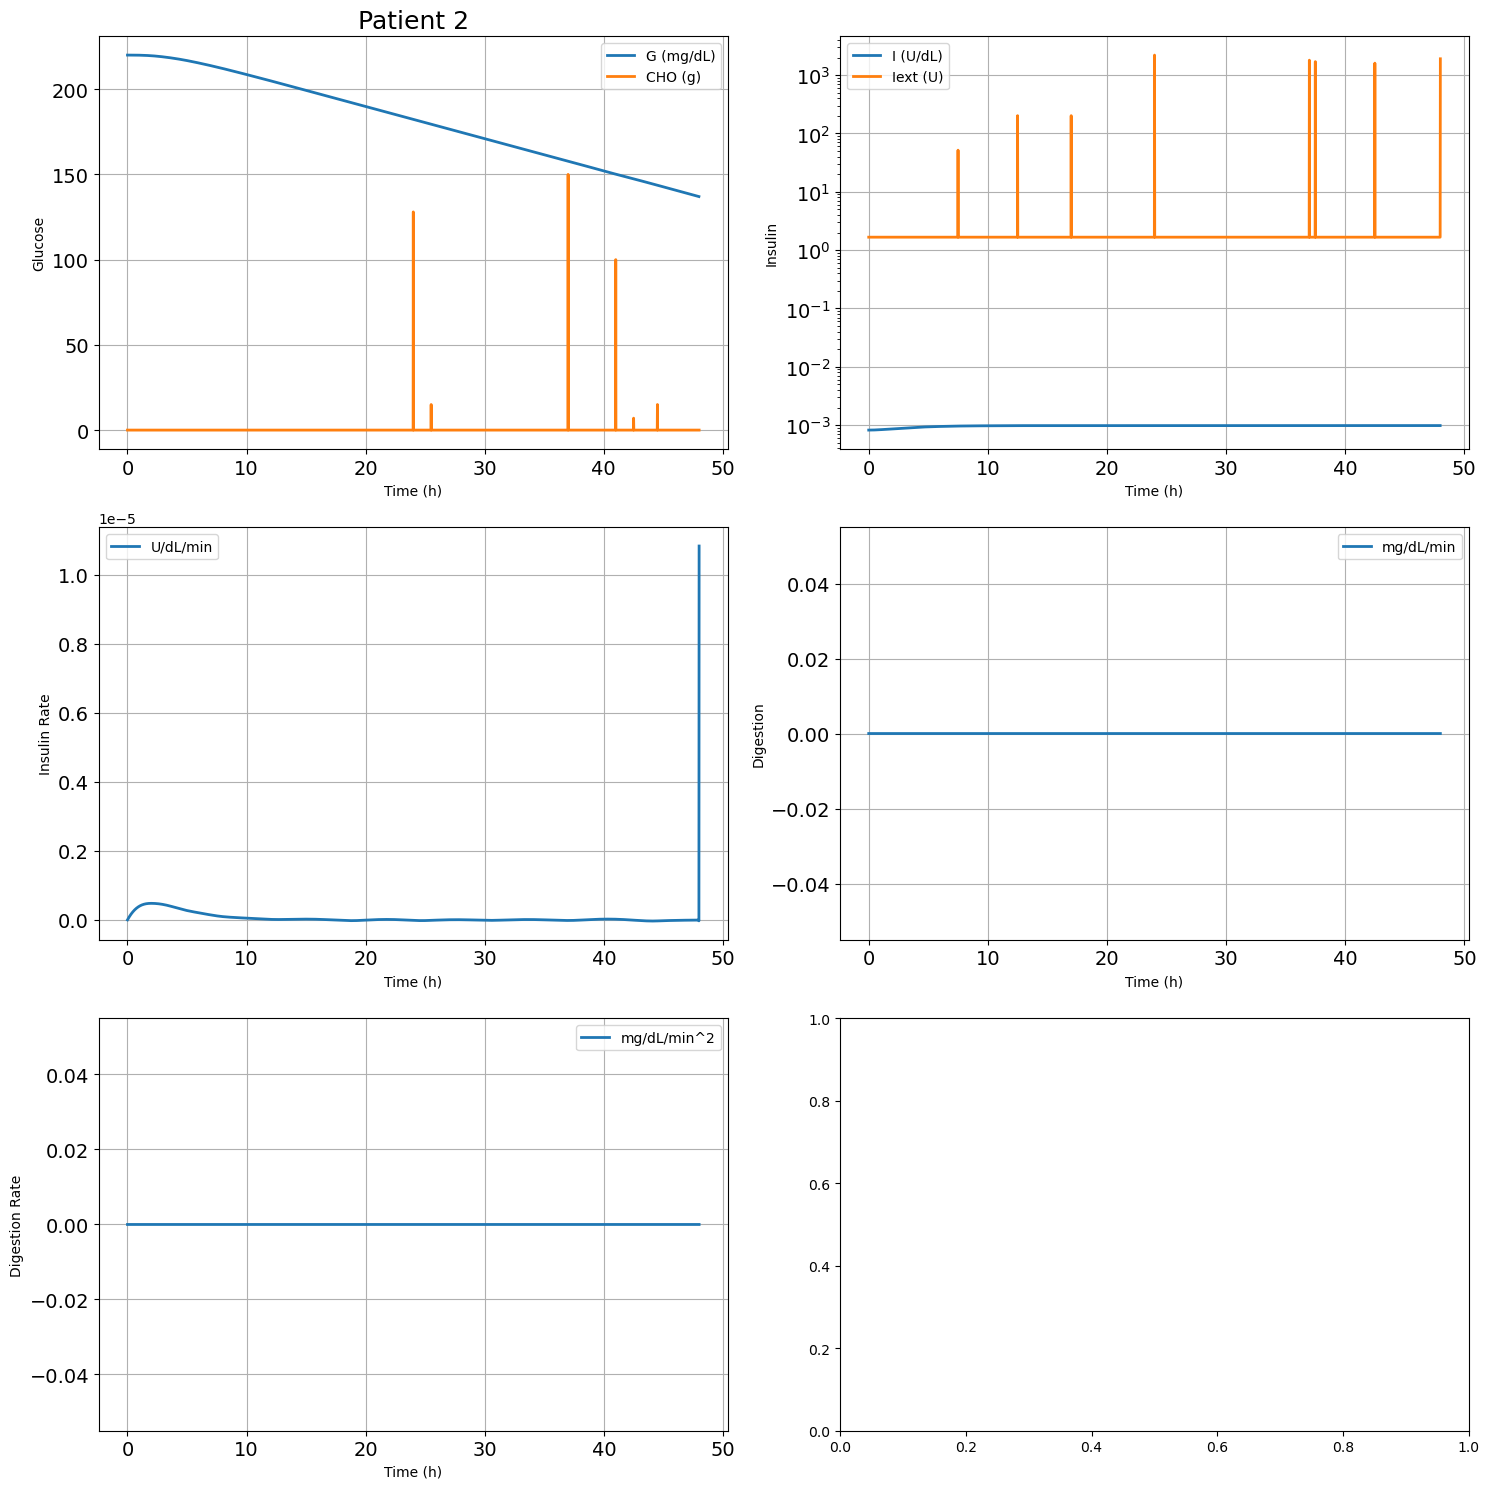

Done.


In [3]:
Magdelaine1(2)

In [12]:
help(solve_ivp)

Help on function solve_ivp in module scipy.integrate._ivp.ivp:

solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
    Solve an initial value problem for a system of ODEs.
    
    This function numerically integrates a system of ordinary differential
    equations given an initial value::
    
        dy / dt = f(t, y)
        y(t0) = y0
    
    Here t is a 1-D independent variable (time), y(t) is an
    N-D vector-valued function (state), and an N-D
    vector-valued function f(t, y) determines the differential equations.
    The goal is to find y(t) approximately satisfying the differential
    equations, given an initial value y(t0)=y0.
    
    Some of the solvers support integration in the complex domain, but note
    that for stiff ODE solvers, the right-hand side must be
    complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
    To solve a problem in the complex domain, pass y0 with a co